# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Имеющиеся признаки :
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
***
При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
***
Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
***
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

#### Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Ход выполнения проекта
1. Загрузка и подготовка данных.
2. Обучение и проверка модели для каждого региона:
    1. Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучаем модель и делаем предсказания на валидационной выборке.
    3. Сохраняем предсказания и правильные ответы на валидационной выборке.
    4. Печатаем на экране средний запас предсказанного сырья и RMSE модели.
    5. Анализируем результаты.
3. Подготовка к расчёту прибыли:
    1. Сохраняем ключевые значения для расчётов в отдельных переменных.
    2. Считаем достаточный объём сырья для безубыточной разработки новой скважины. Сравниваем полученный объём сырья со средним запасом в каждом регионе.
    3. Выводы по этапу подготовки расчёта прибыли.
4. Пишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выбераем скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.
    2. Суммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитаем прибыль для полученного объёма сырья.
5. Считаем риски и прибыль для каждого региона:
    1. Применяем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Находим среднюю прибыль, 95%-й доверительный интервал и риск убытков.
    3. Выводы: предлагаем регион для разработки скважин.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

*Создаем список из регионов*

In [2]:
regions = []
regions.append(pd.read_csv('/datasets/geo_data_0.csv'))
regions.append(pd.read_csv('/datasets/geo_data_1.csv'))
regions.append(pd.read_csv('/datasets/geo_data_2.csv'))

### Анализ первого региона

In [3]:
regions[0].head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
regions[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


*Ищем и удаляем дубликаты скважин*

In [5]:
regions[0]['id'].duplicated().sum()

10

In [6]:
regions[0]['id'].drop_duplicates(inplace = True)

*Убираем поле id, для исследований оно не поможет*

In [7]:
name_feat = regions[0].drop('id', axis = 1).columns.to_list()

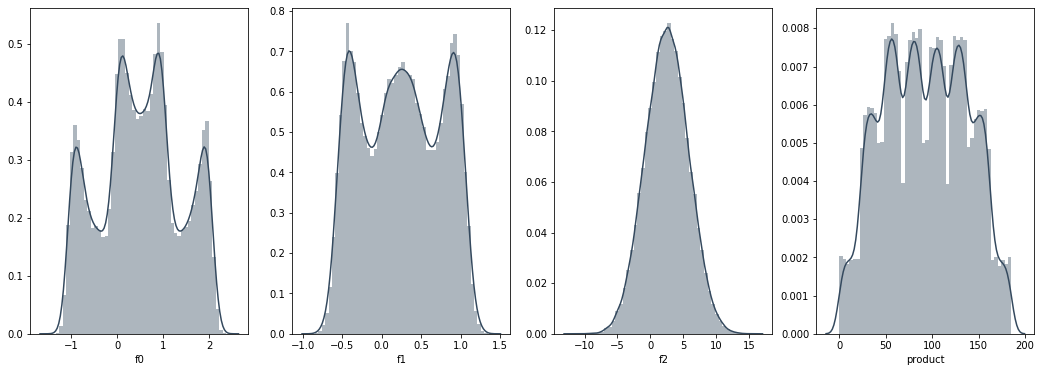

In [8]:
f, ax = plt.subplots(1, 4, figsize=(18, 6))
for name in name_feat:
    sns.distplot(regions[0][name], ax=ax[name_feat.index(name)], kde = True, color = '#34495e')

*Распределения достаточно симметричны. Признак f2 даже имеет нормальное распределение. В Product наблюдается разделение скважин на группы по уровню добычи (примерно 8 групп).*

In [9]:
regions[0]['product'].value_counts(bins = 8)

(46.341, 69.512]      16473
(69.512, 92.682]      16466
(115.853, 139.023]    16241
(92.682, 115.853]     16159
(139.023, 162.194]    12697
(23.171, 46.341]      12688
(-0.186, 23.171]       4677
(162.194, 185.364]     4599
Name: product, dtype: int64

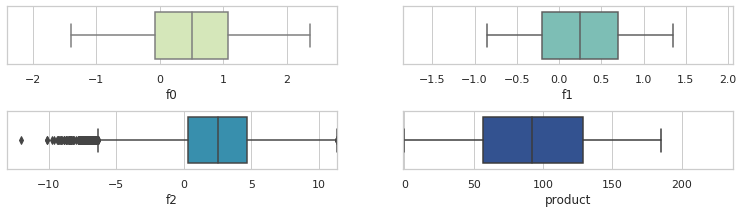

In [10]:
current_palette = sns.color_palette('YlGnBu', n_colors=4)
sns.set(style="whitegrid")
fig, axes= plt.subplots(2, 2, figsize=(13, 3));
fig.subplots_adjust(hspace = .8)
ax = axes.flatten()
i = 0

for name in name_feat:
    iqr = (regions[0][name].quantile(0.75) - regions[0][name].quantile(0.25)) * 1.5
    ax[i].set_xlim(regions[0][name].min()-1, iqr + regions[0][name].quantile(0.75)) * 7
    sns.boxplot(x=name, data = regions[0], color = current_palette[i],
            orient="h", ax = ax[i])
    i += 1

*Большого разброса нет, медиана расположена около среднего.*

In [11]:
regions[0][name_feat].corr(method = 'spearman')

,f0,f1,f2,product
f0,1.000000,-0.471395,-0.002685,0.128417
f1,-0.471395,1.000000,0.001413,-0.181143
f2,-0.002685,0.001413,1.000000,0.486394
product,0.128417,-0.181143,0.486394,1.000000


*Есть отрицательная корреляция признаков f0/f1, положительная f2/product. Посмотрим на диаграмме рассеивания.*

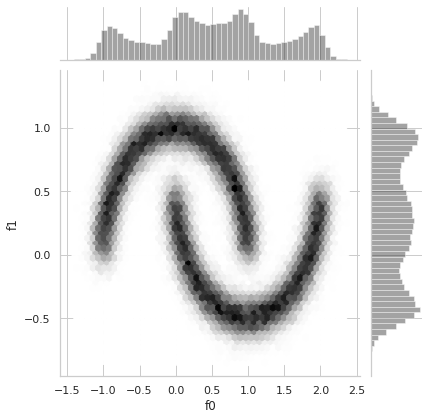

In [12]:
sns.jointplot(x=regions[0]['f0'], y=regions[0]['f1'], kind="hex", color="k");

*Несмотря на разброс точек в виде двух парабол обратная зависимость остается монотонной*

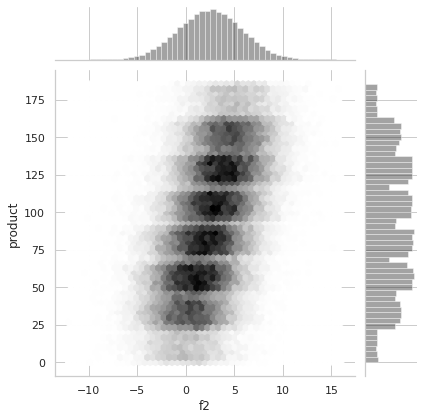

In [13]:
sns.jointplot(x=regions[0]['f2'], y=regions[0]['product'], kind="hex", color="k");

*Есть существенная зависимость целевого признака от параметра f2*

**Итого: есть зависимость целевого признака product от f2, а f0 и f1 компенсируют друг друга.**

### Анализ второго региона

In [14]:
regions[1].head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [15]:
regions[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


*Ищем и удаляем дубликаты скважин*

In [16]:
regions[1]['id'].duplicated().sum()

4

In [17]:
regions[1]['id'].drop_duplicates(inplace = True)

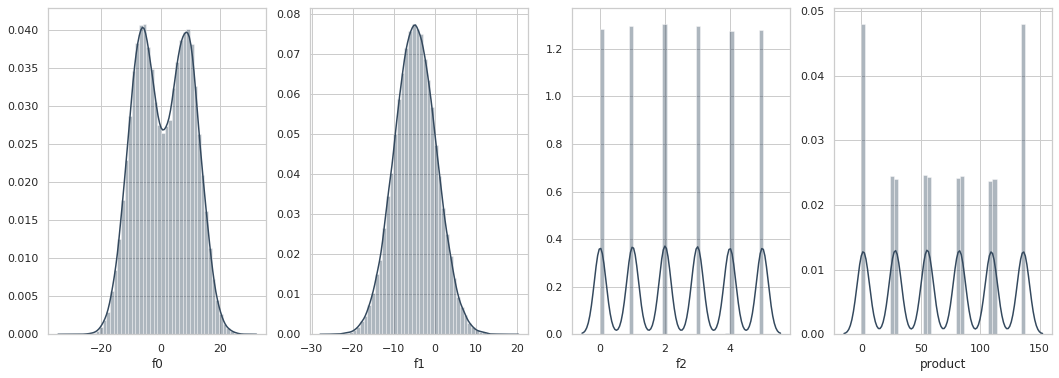

In [18]:
f, ax = plt.subplots(1, 4, figsize=(18, 6))
for name in name_feat:
    sns.distplot(regions[1][name], ax=ax[name_feat.index(name)], kde = True, color = '#34495e')

*Распределения достаточно симметричны. Признак f1 имеет нормальное распределение. В Product скважины очень четко распределы на группы (примерно 12 групп) с большими кол-вом скважин с нулем в добыче и большим с кол-вом, равным 140. Похожее разбиение есть в признаке f2.*

In [19]:
regions[1]['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

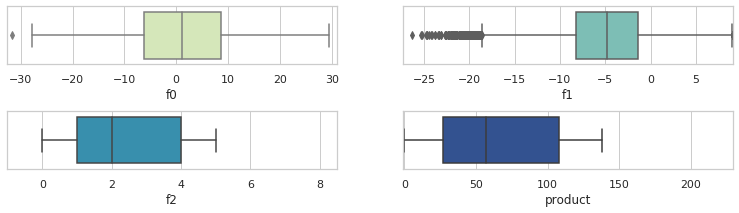

In [20]:
current_palette = sns.color_palette('YlGnBu', n_colors=4)
sns.set(style="whitegrid")
fig, axes= plt.subplots(2, 2, figsize=(13, 3));
fig.subplots_adjust(hspace = .8)
ax = axes.flatten()
i = 0

for name in name_feat:
    iqr = (regions[1][name].quantile(0.75) - regions[1][name].quantile(0.25)) * 1.5
    ax[i].set_xlim(regions[1][name].min()-1, iqr + regions[1][name].quantile(0.75)) * 7
    sns.boxplot(x=name, data = regions[1], color = current_palette[i],
            orient="h", ax = ax[i])
    i += 1

*f0, f1 разброса нет, медиана расположена около среднего. В f2 и в product есть большие значения, которые тянут среднюю за собой. Может нам говорить о наличии скважин с потенциально большим объемом добычи в данном регионе.*

In [21]:
regions[1]['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [22]:
regions[1][name_feat].corr(method = 'spearman')

,f0,f1,f2,product
f0,1.000000,0.182248,-0.002000,-0.122869
f1,0.182248,1.000000,-0.003678,-0.033908
f2,-0.002000,-0.003678,1.000000,0.975605
product,-0.122869,-0.033908,0.975605,1.000000


*Есть очень сильная корреляция признаков f2/product, в данном регионе наша добыча практически полностью зависима от параметра f2. Посмотрим на диаграмме рассеивания.*

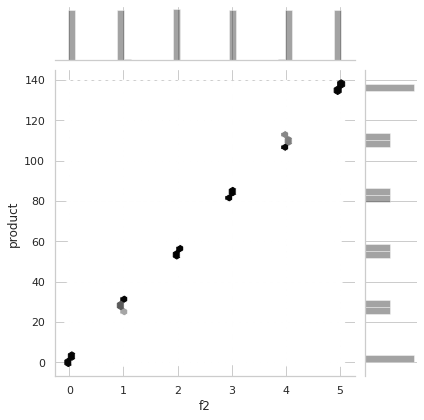

In [23]:
sns.jointplot(x=regions[1]['f2'], y=regions[1]['product'], kind="hex", color="k");

### Анализ третьего региона

In [24]:
regions[2].head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [25]:
regions[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


*Ищем и удаляем дубликаты скважин*

In [26]:
regions[2]['id'].duplicated().sum()

4

In [27]:
regions[2]['id'].drop_duplicates(inplace = True)

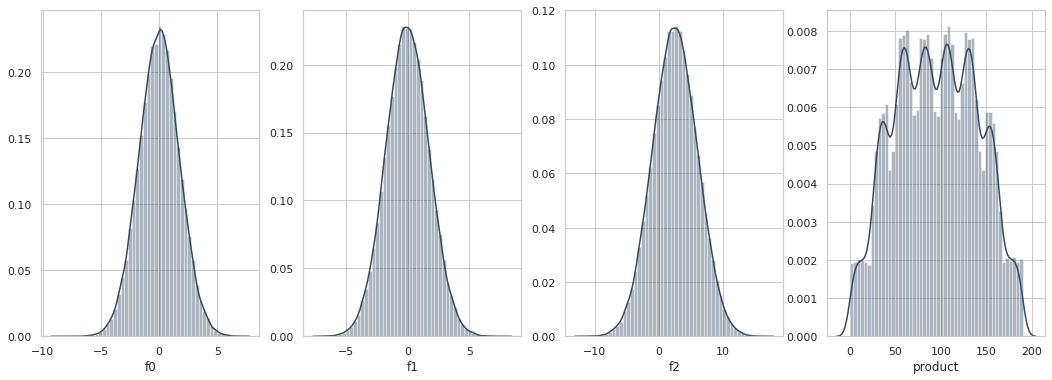

In [28]:
f, ax = plt.subplots(1, 4, figsize=(18, 6))
for name in name_feat:
    sns.distplot(regions[2][name], ax=ax[name_feat.index(name)], kde = True, color = '#34495e')

*Распределения достаточно симметричны. Признак f0,f1,f2 имеют нормальное распределение. В Product наблюдается разделение скважин на группы по уровню добычи (примерно 8 групп).*

In [29]:
regions[2]['product'].value_counts(bins = 8)

(95.015, 118.769]     16768
(71.261, 95.015]      16759
(47.507, 71.261]      16589
(118.769, 142.522]    16536
(23.754, 47.507]      12093
(142.522, 166.276]    11884
(166.276, 190.03]      4755
(-0.191, 23.754]       4616
Name: product, dtype: int64

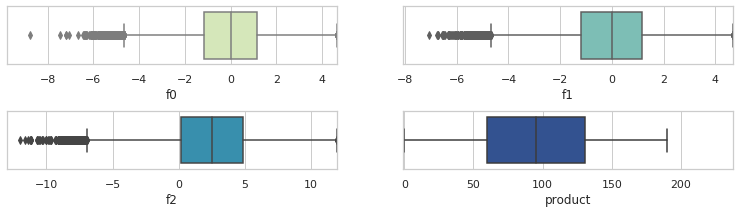

In [30]:
current_palette = sns.color_palette('YlGnBu', n_colors=4)
sns.set(style="whitegrid")
fig, axes= plt.subplots(2, 2, figsize=(13, 3));
fig.subplots_adjust(hspace = .8)
ax = axes.flatten()
i = 0

for name in name_feat:
    iqr = (regions[2][name].quantile(0.75) - regions[2][name].quantile(0.25)) * 1.5
    ax[i].set_xlim(regions[2][name].min()-1, iqr + regions[2][name].quantile(0.75)) * 7
    sns.boxplot(x=name, data = regions[2], color = current_palette[i],
            orient="h", ax = ax[i])
    i += 1

*Большого разброса нет, медиана расположена около среднего.*

In [31]:
regions[2][name_feat].corr(method = 'spearman')

,f0,f1,f2,product
f0,1.000000,0.002493,0.000053,-0.002464
f1,0.002493,1.000000,0.000378,-0.001463
f2,0.000053,0.000378,1.000000,0.448463
product,-0.002464,-0.001463,0.448463,1.000000


*Есть положительная корреляция f2/product. Посмотрим на диарамме рассеивания.*

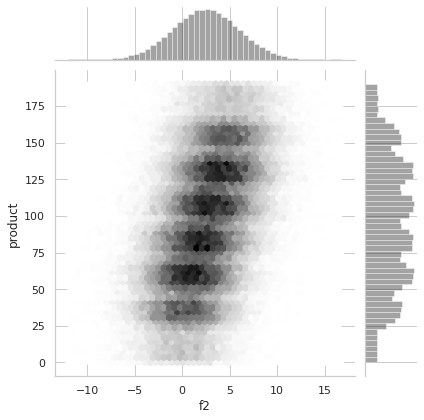

In [32]:
sns.jointplot(x=regions[2]['f2'], y=regions[2]['product'], kind="hex", color="k");

*Есть существенная зависимость целевого признака от параметра f2*

**Во всех регионах есть зависимость (разной силы) целевого признака от параметра f2. Во втором регионе есть пик на скважинах с большим объемом добычи.**

# 2. Обучение и проверка модели

*Делим признаки регионов*

In [33]:
target = []
features = []
for region in regions:
    target.append(region['product'])
    features.append(region.drop(['product','id'] , axis=1))

In [34]:
name_feat.remove('product')

*Разбиваем данные по регионам на тренировочную и валидационную выборки в соотношении 75/25*

In [35]:
features_train = [None,None,None]
features_valid = [None,None,None]
target_train = [None,None,None] 
target_valid = [None,None,None]

for i in [0,1,2]:
    
    features_train[i], features_valid[i], target_train[i], target_valid[i]= (
        
    train_test_split(features[i], target[i], test_size=0.25, random_state=12345)
                                                                            )

*Масштабируем признаки регионов (при последующем проверке без масштабирования модель показала те же результаты)*

In [36]:
pd.options.mode.chained_assignment = None  # default='warn'

scaler = StandardScaler()
for i in [0,1,2]:
    
     scaler.fit(features_train[i].loc[:,name_feat])
    
     features_train[i].loc[:,name_feat] = scaler.transform(features_train[i].loc[:,name_feat])
    
     features_valid[i].loc[:,name_feat] = scaler.transform(features_valid[i].loc[:,name_feat])

*Создаем модели, обучаем и предсказываем*

In [37]:
model = []
for i in [0,1,2]:
    model.append(LinearRegression())

In [38]:
predicted_valid = [1,2,3]
for i in [0,1,2]:
    model[i].fit(features_train[i], target_train[i])
    predicted_valid[i] = model[i].predict(features_valid[i])

In [53]:
len(predicted_valid[1])

25000

In [39]:
mse = []
mse_const = []
predicted_val_const = []
for i in [0,1,2]:
    mse.append(mean_squared_error(target_valid[i], predicted_valid[i]))
    predicted_val_const.append(pd.Series(target_valid[i].mean(), target_valid[i].index))
    mse_const.append(mean_squared_error(target_valid[i], predicted_val_const[i]))
    print('Модель: {} региона Среднее: {:.2f}; RMSE : {:.2f}, RMSE_const : {:.2f}'
          .format(i,predicted_valid[i].mean(), mse[i] ** .5, mse_const[i] ** .5))
    

Модель: 0 региона Среднее: 92.59; RMSE : 37.58, RMSE_const : 44.29
Модель: 1 региона Среднее: 68.73; RMSE : 0.89, RMSE_const : 46.02
Модель: 2 региона Среднее: 94.97; RMSE : 40.03, RMSE_const : 44.90


*Вторая по счету модель показывает наименьшую среднеквадратическую ошибку (видна жесткая связь целевого признака с f2 - модели проще обучится, существенного разброса нет), при наименьшем среднем предсказанном объеме запасов в скважинах и наибольшей разнице с константной моделью - метрика RMSE очень чувствительна к выбросам.*

# 3. Подготовка к расчёту прибыли

In [40]:
POINTS = 500  
BEST_POINTS = 200 
BUDGET =  10000000000
BURREL = 450000 

In [41]:
product = BUDGET / (BURREL * BEST_POINTS)
print('Достаточный объём сырья для безубыточной разработки новой скважины : {:.2f}'
      .format(product))

Достаточный объём сырья для безубыточной разработки новой скважины : 111.11


*Средние запасы в скважине в каждом регионе не дотягивают до безубыточной разработки. Но это показатели средние, на деле есть крупные и мелкие скважины (разница особенно ощутима во втором регионе), их нужно будет отсоритровать и выбрать самые объемные.*

# 4. Расчёт прибыли и рисков 

Пишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

1. Сортируем скважины по предсказанному объему, выбираем 200 лучших, так как именно по этому количеству необходимо рассчитывать прибыль.

1. Суммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

1. Рассчитаем прибыль для полученного объёма сырья (умножаем объем сырья на цена за баррель, из этой суммы вычитаем наш бюджет на регион.)

In [42]:
def revenue(target, probabilities):
    
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False)
    
    selected = pd.Series(target).reset_index(drop = True)[probs_sorted.index][:200]
    
    product = selected.sum()
    
    revenue =  product * BURREL
    
    return revenue - BUDGET

*Фактические данные показывают следующий профит по регионам*

In [43]:
for i in [0,1,2]:
    print('Профит {} лучших скважин {} региона : {:.2f} руб.'
          .format(BEST_POINTS, i, revenue(target_valid[i], predicted_valid[i])))

Профит 200 лучших скважин 0 региона : 3320826043.14 руб.
Профит 200 лучших скважин 1 региона : 2415086696.68 руб.
Профит 200 лучших скважин 2 региона : 2710349963.60 руб.


*Но нам необходимо понять вероятностное распределение прибыли по регионам, чтобы рассчитать доверительный интервал и риски убытков*

# 5. Подсчет рисков и прибыли для каждого региона

*Чтобы рассчитать доверительный интервал прибыли и риски, создадим 1000 подвыборок по 500 скважин каждого региона и подсчитаем прибыль*

In [44]:
state = np.random.RandomState(12345)
    
values = { 0:[], 1:[], 2:[]}
for i in [0,1,2]:   
    for j in range(1000):
        target_sub = target_valid[i].reset_index(drop = True).sample(n = POINTS, replace = True, random_state = state)
        probs_sub = predicted_valid[i][target_sub.index]
        rev = revenue(target_sub, probs_sub)
        values[i].append(rev)

In [45]:
data_revenue = pd.DataFrame(values)
data_revenue.columns = ['first','second','third']
data_revenue.head()

,first,second,third
0,6.054641e+08,3.178949e+08,7.433808e+08
1,5.363934e+08,1.010041e+08,5.687995e+08
2,2.937858e+08,1.295538e+08,2.468884e+08
3,1.789934e+08,5.105900e+08,3.901355e+08
4,2.719929e+08,5.512065e+08,5.309689e+08


In [46]:
profit_list = data_revenue.columns.to_list()

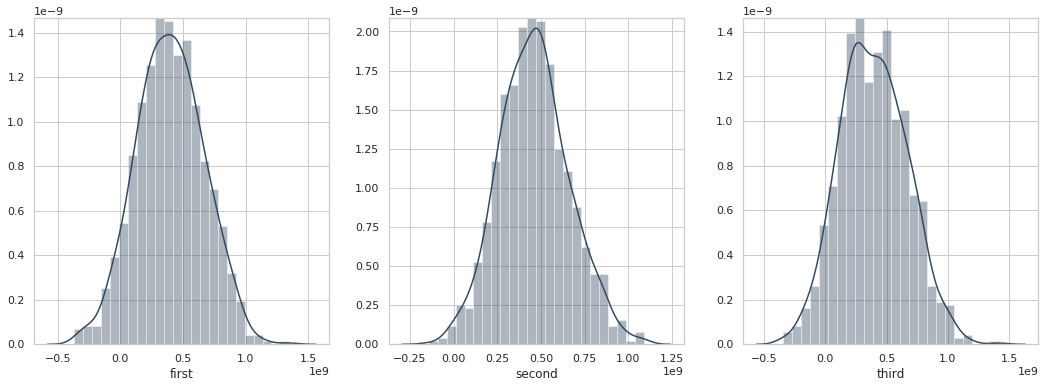

In [47]:
f, ax = plt.subplots(1, 3, figsize=(18, 6))
for lst in profit_list:
    sns.distplot(data_revenue[lst], ax=ax[profit_list.index(lst)], 
                 kde = True, color = '#34495e')

In [48]:
data_revenue.mean()

first     3.961650e+08
second    4.611558e+08
third     3.929505e+08
dtype: float64

In [49]:
lower = []
upper = []
for lst in profit_list:
    lower.append(data_revenue[lst].quantile(.025))
    upper.append(data_revenue[lst].quantile(.975))
    print('Модель : {}, Нижняя граница : {:.2f}, Верхняя граница : {:.2f}'
          .format(profit_list.index(lst), lower[profit_list.index(lst)], 
                  upper[profit_list.index(lst)]))

Модель : 0, Нижняя граница : -111215545.89, Верхняя граница : 909766941.55
Модель : 1, Нижняя граница : 78050810.75, Верхняя граница : 862952060.26
Модель : 2, Нижняя граница : -112227625.38, Верхняя граница : 934562914.55


*После процедуры bootstrap, второй регион показывает наилучшие показатели по средней прибыли. Так же в доверительном интервале (95%) нет убыточных показателей.*

*Рассчитаем риск убытков. Поделим кол-во убыточных скважин на общее количество*

In [50]:
display('Риски убытков при освоениие регонов %:',
    data_revenue[data_revenue[profit_list] < 0].count() / data_revenue.shape[0] * 100)

'Риски убытков при освоениие регонов %:'

first     6.9
second    0.7
third     6.5
dtype: float64

*Наименьший риск показывает модель второго региона - меньше 1%*

### Выводы: 
#### Исходя из следующих показателей предлагаю выбрать для освоения второй регион:
1. Изначально на диаграмме разброса наблюдались расхождение между медианой и средним, следовательно есть большое кол-во скважин с потенциально большими объемами запасов нефти.
2. Модель второго региона показала наименьшую среднеквадратическую ошибку (меньше 1000 баррель), у конкурентов около 40000, следовательно вторая модель точнее (высокая корреляция с признаком f2 на это влияет).
3. Второй регион показывает наивысшую среднюю прибыль
4. С вероятностью 95% освоение данного региона будет прибыльно (в отличие от "конкурентов")
5. Риск убытков при освоении второго региона - меньше процента!

## Было сделано:
1. Загружены и подготовлены данные.
2. Обучены и проверены модели для каждого региона:
    1. Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучили модель и сделали предсказания на валидационной выборке.
    3. Сохранили предсказания и правильные ответы на валидационной выборке.
    4. Напечатали средний запас предсказанного сырья и RMSE модели.
    5. Проанализировали результаты.
3. Подготовили данные к расчёту прибыли:
    1. Сохранили ключевые значения для расчётов в отдельных переменных.
    2. Посчитали достаточный объём сырья для безубыточной разработки новой скважины. Сравнили полученный объём сырья со средним запасом в каждом регионе.
    3. Сделали выводы.
4. Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выбрали скважины с максимальными значениями предсказаний. 
    2. Просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Посчитали прибыль для полученного объёма сырья.
5. Посчитали риски и прибыль для каждого региона:
    1. Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков.
    3. Выводы: предложиил регион для разработки скважин.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован